# `transformers` meets `bitsandbytes` for democratzing Large Language Models (LLMs) through 4bit quantization

<center>
<img src="https://github.com/huggingface/blog/blob/main/assets/96_hf_bitsandbytes_integration/Thumbnail_blue.png?raw=true" alt="drawing" width="700" class="center"/>
</center>

Welcome to this notebook that goes through the recent `bitsandbytes` integration that includes the work from XXX that introduces no performance degradation 4bit quantization techniques, for democratizing LLMs inference and training.

In this notebook, we will learn together how to load a large model in 4bit (`gpt-neo-x-20b`) and train it using Google Colab and PEFT library from Hugging Face 🤗.

[In the general usage notebook](https://colab.research.google.com/drive/1ge2F1QSK8Q7h0hn3YKuBCOAS0bK8E0wf?usp=sharing), you can learn how to propely load a model in 4bit with all its variants.

If you liked the previous work for integrating [*LLM.int8*](https://arxiv.org/abs/2208.07339), you can have a look at the [introduction blogpost](https://huggingface.co/blog/hf-bitsandbytes-integration) to lean more about that quantization method.


First let's load the model we are going to use - GPT-neo-x-20B! Note that the model itself is around 40GB in half precision

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "EleutherAI/polyglot-ko-5.8b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained( 
    model_id, quantization_config=bnb_config, device_map={"":0},
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    )


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/usr/local/cuda/lib64/libcudart

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [2]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [4]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 3670016 || all params: 3070156800 || trainable%: 0.11953838970048696


sft 데이터셋 가져오기

In [5]:
import json
# from google.colab import drive
# drive.mount('/content/drive')

with open('../data/new/sft-hantu.json', 'r') as f:
    sft = json.load(f)

sft[0]

{'instruction': '',
 'input': '',
 'output': '바다에서 출항, 귀환, 분실된 선박의 수가 표시된 표로 이어지는 단계는 다음과 같습니다:\n\n1. 문제 문장은 선장이 디스커버리, 엔데버, 어드벤처, 챌린저, 익스플로러 등 다섯 척의 배를 이끌고 탐험을 떠났다고 알려줍니다.\n2. 그 중 두 척의 배인 챌린저 호와 익스플로러 호가 폭풍 속에서 길을 잃었습니다. 즉, 디스커버리호, 엔데버호, 어드벤처호 등 세 척의 배만 탐험에서 돌아왔습니다.\n3. 정보를 요약하기 위해 두 개의 열이 있는 테이블을 만들 수 있습니다. 하나는 선박의 상태(해상에서 반환 또는 분실)를 나타내는 열이고 다른 하나는 해당 상태를 가진 선박의 수를 나타내는 열입니다.\n4. 탐험에 참여했던 5척의 선박을 모두 설명하기 위해 테이블에 "출항" 행을 추가합니다. 출항한 선박의 수는 문제 설명에 명시된 대로 5척입니다.\n5. 따라서 최종 표는 다음과 같습니다:\n\n| 상태 | 배의 수 |\n| --- | --- |\n| 출발 | 5 |\n| 귀환 | 3 |\n| 해상에서 분실 | 2 |',
 'history': "<|User|>: 스미스 선장은 디스커버리호, 인데버호, 어드벤처호, 챌린저호, 익스플로러호로 구성된 함대를 이끌고 대담한 탐험을 떠났습니다. 그들의 임무는 북대서양의 험난한 바다를 통과하는 새로운 항로를 개척하고 조국의 새로운 영토를 확보하는 것이었습니다. 하지만 날씨는 그들에게 불리하게 바뀌었고, 그들은 사나운 폭풍과 격렬한 해류와 싸워야 했습니다. 파도는 점점 더 높아졌고 바람은 밴시처럼 울부짖으며 언제 배가 전복될지 모른다고 위협했습니다. 챌린저 호와 익스플로러 호는 그들의 노력에도 불구하고 폭풍에 휩쓸려 길을 잃었습니다. \n\n선장은 몇 척의 배와 함께 떠났고 몇 척이 돌아왔을까요?\n<|AI|>: 선장은 디스커버리호, 엔데버호, 어드벤처호, 챌린저호, 익스플로러호 등 다섯 척의 배를 이끌고 탐험을 떠났습니다. 하지만 두 척의 배, 챌

In [6]:
import copy
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence
import transformers
from torch.utils.data import Dataset
import random
import torch

### for tokenizer
random.seed(777)
IGNORE_INDEX = -100

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_qna": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n<|qna_start|>{instruction}<|qna_end|>\n\n### Response:"
    ),
    "prompt_chat": (
        "Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.\n\n"
        "### Instruction:\nWrite the last AI response to complete the dialog.\n\n"
        "### Dialog:\n<|AI|>: 안녕하세요, 무엇을 도와드릴까요?\n{history}\n<|AI|>:\n\n"
        "### Response:\n"
    )
}

def _tokenize_fn(
    strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer
) -> Dict:
    """Tokenize a list of strings."""
    tokenized_list = [
        tokenizer(
            text,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )
        for text in strings
    ]
    input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
    input_ids_lens = labels_lens = [
        tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item()
        for tokenized in tokenized_list
    ]
    return dict(
        input_ids=input_ids,
        labels=labels,
        input_ids_lens=input_ids_lens,
        labels_lens=labels_lens,
    )


def preprocess(
    sources: Sequence[str],
    targets: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:
    """Preprocess the data by tokenizing."""
    examples = [s + t for s, t in zip(sources, targets)]
    examples_tokenized, sources_tokenized = [
        _tokenize_fn(strings, tokenizer) for strings in (examples, sources)
    ]
    input_ids = examples_tokenized["input_ids"]
    labels = copy.deepcopy(input_ids)
    for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
        label[:source_len] = IGNORE_INDEX
    return dict(input_ids=input_ids, labels=labels)


class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""

    def __init__(self, data_path: str, tokenizer: transformers.PreTrainedTokenizer):
        super(SupervisedDataset, self).__init__()
        print("Loading data...")
        with open(data_path, 'r') as f:
            list_data_dict = json.load(f)
        random.shuffle(list_data_dict)  # shuffle data

        print("Formatting inputs...")
        prompt_input, prompt_no_input, prompt_chat, prompt_qna = (
            PROMPT_DICT["prompt_input"],
            PROMPT_DICT["prompt_no_input"],
            PROMPT_DICT["prompt_chat"],
            PROMPT_DICT["prompt_qna"],
        )
#         sources = [
#             prompt_input.format_map(example)
#             if example.get("input", "") != ""
#             else prompt_no_input.format_map(example)
#             for example in list_data_dict
#         ]
        sources = []
        for example in list_data_dict:
            if example.get("qna", 0) == 1:
                exfmt = prompt_qna.format_map(example)
            elif example.get("history", "") != "":
                exfmt = prompt_chat.format_map(example)
            elif example.get("input", "") != "":
                exfmt = prompt_input.format_map(example)
            else:
                exfmt = prompt_no_input.format_map(example)
            sources.append(exfmt)
        targets = [
            f"{example['output']}{tokenizer.eos_token}" for example in list_data_dict
        ]

        print("Tokenizing inputs... This may take some time...")
        data_dict = preprocess(sources, targets, tokenizer)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple(
            [instance[key] for instance in instances] for key in ("input_ids", "labels")
        )
        # print("[input_ids]:", tokenizer.decode(input_ids))
        # print("[labels]:", labels)
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(
            labels, batch_first=True, padding_value=IGNORE_INDEX
        )
        ret = dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )
        # print(ret)
        return ret


def make_supervised_data_module(
    tokenizer: transformers.PreTrainedTokenizer, data_path
) -> Dict:
    """Make dataset and collator for supervised fine-tuning."""
    train_dataset = SupervisedDataset(
        tokenizer=tokenizer, data_path=data_path
    )
    data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)
    return dict(
        train_dataset=train_dataset, eval_dataset=None, data_collator=data_collator
    )



Run the cell below to run the training! For the sake of the demo, we just ran it for few steps just to showcase how to use this integration with existing tools on the HF ecosystem.

In [7]:
tokenizer.model_max_length = 2048  # chat 데이터 추가시 반드시 2048 까지는 늘려줘야 함
data_path = '../data/new/sft-hantu.json'
# data_path = '/content/drive/MyDrive/gpt/sft-smp-1000.json'

data_module = make_supervised_data_module(tokenizer=tokenizer, data_path=data_path)

Loading data...
Formatting inputs...
Tokenizing inputs... This may take some time...


In [8]:
n = 13
print(''.join(tokenizer.batch_decode(data_module['train_dataset'][n]['input_ids'])))
# print(''.join(tokenizer.batch_decode(data_module['train_dataset'][n]['labels'])))
# data_module['train_dataset'][0]

Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.

### Instruction:
Write the last AI response to complete the dialog.

### Dialog:
<|AI|>: 안녕하세요, 무엇을 도와드릴까요?
<|User|>: RITE ONE WORS
<|AI|>:

### Response:
죄송합니다. 요청하신 내용을 이해하지 못했습니다. 자세한 정보를 제공하거나 질문을 명확히 설명해 주시겠습니까?<|endoftext|>


In [9]:
import transformers

trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=10,
        gradient_accumulation_steps=32,
        learning_rate=2e-5,
        warmup_ratio=0.03,
        lr_scheduler_type='cosine',
        weight_decay=0,
        num_train_epochs=15,
#         num_train_epochs=8,
        save_strategy="epoch",
#         save_steps=1000,
        save_total_limit=5,
        report_to="none",
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit",
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    **data_module,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss
1,2.478400
2,2.407400
3,2.351700
4,2.451000
5,2.461800
6,2.426600
7,2.403600
8,2.352800
9,2.452200
10,2.475200


TrainOutput(global_step=135, training_loss=2.051643240010297, metrics={'train_runtime': 30389.3261, 'train_samples_per_second': 1.532, 'train_steps_per_second': 0.004, 'total_flos': 8.00742633751511e+17, 'train_loss': 2.051643240010297, 'epoch': 13.89})

In [10]:
# save lora
model.save_pretrained('lora-hantu')

# merge lora weight
# https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora.py#L409
# merged_lora_model = model.merge_and_unload()

# # save merged model
# merged_lora_model.save_pretrained("outputs")


In [11]:
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)
df

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.4784,4.000000e-06,0.10,1,NaN,NaN,NaN,NaN,NaN
1,2.4074,8.000000e-06,0.21,2,NaN,NaN,NaN,NaN,NaN
2,2.3517,1.200000e-05,0.31,3,NaN,NaN,NaN,NaN,NaN
3,2.4510,1.600000e-05,0.41,4,NaN,NaN,NaN,NaN,NaN
4,2.4618,2.000000e-05,0.51,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
131,1.9006,2.626850e-08,13.58,132,NaN,NaN,NaN,NaN,NaN
132,1.9277,1.167773e-08,13.68,133,NaN,NaN,NaN,NaN,NaN
133,1.9624,2.919859e-09,13.79,134,NaN,NaN,NaN,NaN,NaN
134,1.9005,0.000000e+00,13.89,135,NaN,NaN,NaN,NaN,NaN


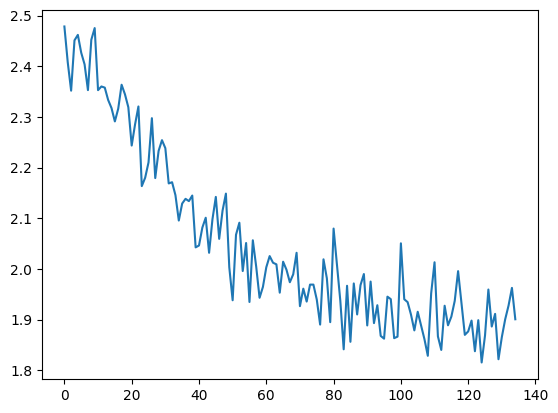

In [12]:
import matplotlib.pyplot as plt

plt.plot(df['loss'])

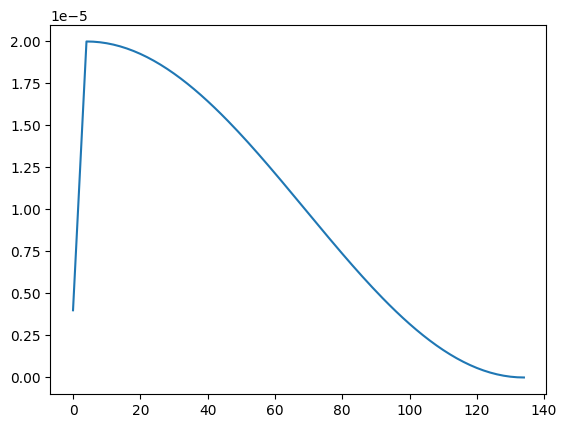

In [13]:
plt.plot(df['learning_rate'])

In [ ]:
aa = [(k,v.dtype) for k,v in mm.state_dict().items()]
bb = [(k,v.dtype) for k,v in model.state_dict().items()]

In [ ]:
len(aa), len(bb)
for a, b in zip(aa, bb):
    if a[1] != b[1]:
        print(a[0], a[1], b[1])
        print('----')

In [ ]:
aa

In [ ]:
!du -h -d 1 ~/.cache/huggingface/hub

In [ ]:
tokenizer.pad_token_id, tokenizer.eos_token_id

In [14]:
    model.state_dict()[
        "base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]

tensor([ 0.0138,  0.0065, -0.0037,  ..., -0.0112,  0.0249, -0.0070],
       device='cuda:0')

## Inference test

In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
# from peft import PeftModel, PeftConfig, LoraModel

# DEVICE = 'cuda'
# peft_model_id = "outputs"
# config = PeftConfig.from_pretrained(peft_model_id)


# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
# tokenizer.pad_token = tokenizer.eos_token  # needed for gpt-neo-x tokenizer

# model = AutoModelForCausalLM.from_pretrained(
#       config.base_model_name_or_path,
#       torch_dtype=torch.float16,
#       # torch_dtype='auto',
#       low_cpu_mem_usage=True,
#       pad_token_id=tokenizer.pad_token_id,
#       eos_token_id=tokenizer.eos_token_id
#     )

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

DEVICE = 'cuda'
peft_model_id = "lora-qnat"
config = PeftConfig.from_pretrained(peft_model_id)


tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token  # needed for gpt-neo-x tokenizer

model = AutoModelForCausalLM.from_pretrained(
      config.base_model_name_or_path,
      torch_dtype=torch.float16,
      # torch_dtype='auto',
      low_cpu_mem_usage=True,
      pad_token_id=tokenizer.pad_token_id,
      eos_token_id=tokenizer.eos_token_id
    )
PeftModel.from_pretrained(model, peft_model_id)

model = model.to(DEVICE)
model.eval()


Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 4096)
    (layers): ModuleList(
      (0-27): 28 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attention): GPTNeoXAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(
            in_features=4096, out_features=12288, bias=True
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=12288, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (dense): Linear(in_fea

In [15]:
from time import time

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_qna": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n<|qna_start|>{instruction}<|qna_end|>\n\n### Response:"
    ),
    "prompt_chat": (
        
        "Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.\n\n"
        "### Instruction:\nWrite the last AI response to complete the dialog.\n\n"
        "### Dialog:\n<|AI|>: 안녕하세요, 무엇을 도와드릴까요?\n{history}\n\n"
        "### Response:\n<|AI|>:"
    )
}

def gen(prompt, user_input=None, is_qna=False, min_new_tokens=10, max_new_tokens=128, temperature=0.5, **kwargs):
    st = time()
    if is_qna:
        x = PROMPT_DICT['prompt_qna'].format(instruction=prompt)
    elif user_input:
        x = PROMPT_DICT['prompt_input'].format(instruction=prompt, user_input=user_input)
    else:
        x = PROMPT_DICT['prompt_no_input'].format(instruction=prompt)

    input_ids = tokenizer.encode(x, return_tensors="pt").to(DEVICE)
    gen_tokens = model.generate(
        inputs = input_ids,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        temperature=temperature,
        no_repeat_ngram_size=6,
        do_sample=True,
        **kwargs
    )
    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)
    end = time()
    print(f"[Elpsed]: {end-st} sec")

    return x, gen_text.replace(x, ''), gen_tokens


def dialog_gen(user_input, history=None, max_new_tokens=128, temperature=0.5, **kwargs):
    st = time()
    if history is None:
        history = []
    history.append({'agent': 'User', 'utterance': user_input})
    history_str = [f"<|{x['agent']}|>: {x['utterance']}" for x in history]
    history_str = '\n'.join(history_str)
    x = PROMPT_DICT['prompt_chat'].format(history=history_str)
    
    input_ids = tokenizer.encode(x, return_tensors="pt").to(DEVICE)
    gen_tokens = model.generate(
        inputs=input_ids, 
        max_new_tokens=max_new_tokens, 
        num_return_sequences=1, 
        temperature=temperature,
        no_repeat_ngram_size=6,
        do_sample=True,
        **kwargs
        
    )
    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)
    response = gen_text.replace(x, '')
    history.append({'agent': 'AI', 'utterance': response})
    end = time()
    print(f"[Elpsed]: {end-st} sec")
    
    return x, response, gen_tokens


In [16]:
history = []
# history = [

#     {'agent': '', 'utterance': ''}
# ]

In [17]:
DEVICE = 'cuda'
with torch.no_grad():
    user_input = '나 지금 너무 배고프다.'
#     user_input = '내가 지금 어떻다고?'
#     user_input = '엥? 뭔소리야 빡치게.'
#     user_input = '일본요리 먹고싶은데 몇 가지 추천해줘.'
#     user_input = '좋아 그럼 식당도 같이 추천해줘.'
#     user_input = '식당 추천해줘.'
#     user_input = '돈부리는 처음 듣는데 이건 무슨 음식이야?'


    prompt, generated_output, gen_tokens = dialog_gen(user_input, history, max_new_tokens=256, temperature=0.1, repetition_penalty=1.4)
    print(generated_output)

    print('---')
    print(history)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


[Elpsed]: 15.808122873306274 sec
 네! 알겠습니다~ 동반성자님의 현재 상태를 고려하여 다음과 같은 음식들 중에서 추천해드리도록 하죠~!�밭1) 단백질이 풍부한 닭가슴살 샐러드(닭고기는 신진대사 촉진에 도움되며 근육량 증가 및 유지에도 효과적입니다), 2) 비타민C가 많고 항산화 작용으로 노화방지와 피부미용 등 건강관리에 좋으며 면역력 향상도 기대할 수 있어 감기 예방이나 피로회복에도 탁월합니다^_^ 또한 철분 함유로 빈혈예방까지 가능하니 일석이조라고 할수있지요!!
---
[{'agent': 'User', 'utterance': '나 지금 너무 배고프다.'}, {'agent': 'AI', 'utterance': ' 네! 알겠습니다~ 동반성자님의 현재 상태를 고려하여 다음과 같은 음식들 중에서 추천해드리도록 하죠~!�밭1) 단백질이 풍부한 닭가슴살 샐러드(닭고기는 신진대사 촉진에 도움되며 근육량 증가 및 유지에도 효과적입니다), 2) 비타민C가 많고 항산화 작용으로 노화방지와 피부미용 등 건강관리에 좋으며 면역력 향상도 기대할 수 있어 감기 예방이나 피로회복에도 탁월합니다^_^ 또한 철분 함유로 빈혈예방까지 가능하니 일석이조라고 할수있지요!!'}]


In [18]:
print(prompt)

Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.

### Instruction:
Write the last AI response to complete the dialog.

### Dialog:
<|AI|>: 안녕하세요, 무엇을 도와드릴까요?
<|User|>: 나 지금 너무 배고프다.

### Response:
<|AI|>:


In [26]:
DEVICE = 'cuda'
with torch.no_grad():
    for i in range(1):
        prompt, generated_ouput, gen_tokens = gen('이체 한도 조정을 인터넷으로 할 수 있을까요?"', is_qna=True, max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('다른 증권사의 계좌를 여기로 옮기는 방법', is_qna=True, max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('대주거래 이용 방법', is_qna=True, max_new_tokens=256, temperature=0.8)
        
        if i == 0:
            print(prompt, '\n', generated_ouput)
        else:
            print(generated_ouput)
        print('='*80, '\n')

[Elpsed]: 7.003485441207886 sec
Below is an instruction that describes a task.

Write a response that appropriately completes the request.

### Instruction:
<|qna_start|>이체 한도 조정을 인터넷으로 할 수 있을까요?"<|qna_end|>

### Response: 
 온라인에서는 고객님의 계좌정보(계좌번호 및 비밀번호)를 확인할 수 없으므로, 입금계좌를 변경하기 위해서는 은행 영업점을 내점하거나 고객센터로 유선 연락하여 계좌번호 및 비밀번호 등을 확인해야 합니다. 공영주



In [24]:
DEVICE = 'cuda'
with torch.no_grad():
    for i in range(1):
#         prompt, generated_ouput, gen_tokens = gen('김치를 만드는 방법을 자세히 설명해줘', max_new_tokens=256, temperature=0.8)
        prompt, generated_ouput, gen_tokens = gen('메타몽에 대해 자세히 설명해줘', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('한국에서 제일 유명한 노래와 그 곡을 부른 가수를 소개해줘.', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('너는 누구냐?', max_new_tokens=256, temperature=0.8)
        if i == 0:
            print(prompt, '\n', generated_ouput)
        else:
            print(generated_ouput)
        print('='*80, '\n')

[Elpsed]: 33.23882055282593 sec
Below is an instruction that describes a task.

Write a response that appropriately completes the request.

### Instruction:
메타몽에 대해 자세히 설명해줘

### Response: 
 메타몽은 포켓몬스터에 등장하는 포켓몬스터이고, 포켓몬 도감에 등록된 일반 포켓몬 중에서 가장 강한 포켓몬입니다. 포켓몬 트레이너들 사이에서도 메타몽에 대한 다양한 종류가 있으며, 메타몽에 대한 정의는 포켓몬 도감에서 보는 것과 크게 다르지 않습니다. 메타몽의 껍질을 탈피하면 진화하게 되고, 그 진화한 포켓몬의 형태에 따라 이름이 각각 다르게 붙여집니다. 메타몽의 경우에는 메타몽의 껍질을 벗으면 일반적인 포켓몬 형태가 아니라 메타몽의 형태를 갖게 되고, 그 형태에 따라 이름이 붙여집니다. 메타몽은 메타몽, 메탕, 메타몽메타몽의 경우에는 일반적인 포켓몬과는 형태가 다르지만 '메타몽'이라는 이름이 붙습니다. 메타몽의 경우 껍질을 벗으면 일반적으로 거북이 형태로 변신합니다. 메타몽메타몽메타몽메탕메탕메탕메타몽메타폼메타폼메타몽메타톤메타톤메타몽메타메타몽메타탄메타탄메타메타메타메타로



In [ ]:
gen_tokens[0]

In [ ]:
tokenizer.batch_decode([0, 1])

In [ ]:
len(tokenizer.encode(generated_ouput))

---
# for merge test

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import (
    get_peft_model,
    get_peft_config,
    get_peft_model_state_dict,
    LoraConfig,
    PeftModel,
    PeftConfig,
)
import pickle

DEVICE = "cuda"
peft_model_id = "adapter"
config = PeftConfig.from_pretrained(peft_model_id)


tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token  # needed for gpt-neo-x tokenizer

model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    torch_dtype=torch.float16,
    # torch_dtype='auto',
    low_cpu_mem_usage=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# 이거는 transformer model임
# 인퍼런스에선 이걸로 사용하면 편함 *.bin 으로 저장된 lora adapter 가중치 로드가능
PeftModel.from_pretrained(model, peft_model_id)

# 모델 로드 체크용 가중치
chk = (
    model.state_dict()[
        "gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]
    .cpu().numpy()
    .copy()
)

In [ ]:
### save lora weight as pickle
# lw = get_peft_model_state_dict(model)

lw = list(filter(lambda x: "lora" in x[0], model.state_dict().items()))
lw = dict(lw)
print("[lora # layer]:", len(lw))
with open("./adapter/lora-weight.pkl", "wb") as f:
    pickle.dump(lw, f)


# lora merge 하려면 peftModel 객체로 변환해야 함
# 학습시 사용한 값 그대로임
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False,
)
# 이거 하는 순간 웨이트 초기화 될수도...
# -> 맞네...
model = get_peft_model(model, peft_config)
chk2 = (
    model.state_dict()[
        "base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]
    .cpu()
    .numpy()
    .copy()
)

In [ ]:
# model.state_dict()['gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight']
# model.state_dict()['base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight']
# peft model 은 'base_model.model' 부분이 키앞에붙는거주의

# model = get_peft_model(model, peft_config)


## LOAD pickle format LORA Weights
def load_model(model, weights):
    model.load_state_dict(weights, strict=False)
    return model


with open("./adapter/lora-weight.pkl", "rb") as f:
    lw = pickle.load(f)
    new_lw = {f"base_model.model.{k}": v for k, v in lw.items()}

model = load_model(model, new_lw)  # .to(DEVICE)
chk3 = (
    model.state_dict()[
        "base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]
    .cpu()
    .numpy()
    .copy()
)

# check
print(f"[orig   lora W]: {chk}")
print(f"[init   lora W]: {chk2}")
print(f"[loaded lora W]: {chk3}")

### merge and save

# merge lora weight
# https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora.py#L409
model.merge_and_unload()

# peftModel -> transformer.model
mm = model.base_model._modules["model"]
type(mm)
# save merged model
# mm.save_pretrained("model")

# ggml 컨버팅 위해 아래 토크나이저 정보 파일 'output'폴더에 같이 옮겨둬야 함
# - special_tokens_map.json
# - tokenizer_config.json
# - tokenizer.json

len(mm.state_dict())
# 424 -> 480 -> 424

In [ ]:
mm.to('cuda')
mm.eval()